In [177]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
os.listdir("results")

['log_1_25.txt',
 'log_1_20.txt',
 'log_0_10.txt',
 'log_0_15.txt',
 'log_0_0.txt',
 'log_0_2.txt',
 'log_0_25.txt',
 'log_0_20.txt',
 'log_0_5.txt',
 'log_1_10.txt',
 'log_1_2.txt',
 'log_1_0.txt',
 'log_1_5.txt',
 'log_1_15.txt']

In [7]:
!cat results/log_1_5.txt

2000, 100, 1, 5531.57, 0.218085
2000, 100, 1, 5531.33, 3.30084
1800, 100, 0.9, 33770.9, 0.238844
1800, 100, 0.9, 33707.9, 1.15707
1600, 100, 0.8, 62283.3, 0.299933
1600, 100, 0.8, 61947.9, 1.97714
1400, 100, 0.7, 90225.3, 0.719717
1400, 100, 0.7, 90145.2, 0.725117
1200, 100, 0.6, 118667, 0.480399
1200, 100, 0.6, 118503, 2.39481
1000, 100, 0.5, 146762, 0.446848
1000, 144, 0.5, 146773, 0.911191
800, 140, 0.4, 175246, 0.051848
800, 356, 0.4, 174915, 3.08662
600, 337, 0.3, 203345, 0.191331
600, 1133, 0.3, 203256, 0.60085
400, 1148, 0.2, 231534, 0.694477
400, 5753, 0.2, 231505, 2.16903
200, 9207, 0.1, 260045, 1.09417
200, 92100, 0.1, 259774, 2.86357
16, 1000000, 0.008, 286123, 24.8796
100, 1000000, 0.05, 273895, 20.5556


### Data structure
- iteration
    - noise level
        - inlier level
            - [num_of_inliers, num_of_iters, cost, time]
            
what can be interesting for us ? 
 - ratio x noise x mean number of inliers
 - ratio x noise x mean cost
 - ratio x noise x mean time
 - ratio x noise x mean number of iterations

 - for inlier ratio = x, plot quantiles of some statistics over noise levels
 - for noise level = x, plot quantiles of some statistics over inlier ratio

In [20]:
from collections import defaultdict

In [202]:
AggrDict = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: [])
        )
    )
)

RansacStatsDict = lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: [])
        )
    )

In [153]:
RESULTS_DIR = "results"
NUMBER_OF_SOLVERS = 2
RATIOS = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
DEVS=[0, 2, 5, 10, 15, 20, 25]

In [146]:
def aggregate_data(dirpath: str, num_of_solvers: int, ratios: list[float]) -> AggrDict:
    res = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: [])
            )
        )
    )
    
    for file in os.listdir(dirpath):
        with open(os.path.join(dirpath, file)) as f:
            data = f.readlines()

        file = file.split(".")[0]
        iteration, noise = map(int, file.split("_")[1:])

        data = [[float(elm) for elm in entry.strip("\n").split(",")] for entry in data]
        data = [[elm if idx == 4 or idx == 2 else int(elm) for idx, elm in enumerate(entry)]\
                for entry in data]

        ratio = 0
        for idx, elm in enumerate(data):
            if idx % num_of_solvers == 0 and idx != 0:
                ratio += 1
            elm.pop(2)
            res[idx % num_of_solvers][iteration][noise][ratios[ratio % len(ratios)]].append(elm)
            
    return DATA

In [148]:
data = aggregate_data(RESULTS_DIR, NUMBER_OF_SOLVERS, RATIOS)

In [149]:
data

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {25: defaultdict(<function __main__.<lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                                   {0.0: [[2000,
                                                      100,
                                                      11079,
                                                      0.173271]],
                                                    0.1: [[1797,
                                                      1483,
                                                      49176,
                                                      0.115121]],
                                                    0.2: [[1582,
                                                      100,
 

In [175]:
# ratio x noise x mean time 
def get_table(data: AggrDict, ratios: list[float], devs: list[float], metric: int):
    
    dev_map = {dev: i for i, dev in enumerate(devs)}
    ratio_map = {ratio: i for i, ratio in enumerate(ratios)}
    
    r1, r2 = data[0], data[1]
    
    def extract_info(r: AggrDict):
        resulting = [[0 for _ in range(len(ratios))] for _ in range(len(devs))]
        
        iters = len(r)
        
        for i in range(iters):
            for dev in r[i]:
                for ratio in r[i][dev]:
                    # print(resulting[dev_map[dev]][ratio_map[ratio]], r[i][dev][ratio][0][metric])
                    resulting[dev_map[dev]][ratio_map[ratio]] += \
                            r[i][dev][ratio][0][metric]
                    
        for i in range(len(ratios)):
            for j in range(len(devs)):
                resulting[j][i] /= iters
                    
        return resulting
    
    return extract_info(r1), extract_info(r2)

In [178]:
r1, r2 = get_table(data, RATIOS, DEVS, 0)

In [220]:
def plot_table(r: RansacStatsDict, title: str):
    plt.figure(figsize=(12,12))
    s = sns.heatmap(r, annot=True, fmt=".2f", linewidths=.5, cmap="YlGnBu",
               xticklabels=RATIOS, yticklabels=DEVS, label="h")
    s.set(xlabel='Ratio of inliers', ylabel='Vertical direction deviation')
    s.set_title(title)
    plt.show()

# plot_table(r1, "Mean number of inliers found: [p2p]")
# plot_table(r2, "Mean number of inliers found: [p3p]")

In [224]:
# for inlier ratio = x, plot quantiles of some statistics over noise levels
def get_quantiles(data: AggrDict, inlier_ratio: float, metric: int):
    noise_levels = defaultdict(lambda: [])
    
    for i in range(len(data)):
        for noise_level in data[i]:
            
            e = data[i][noise_level][inlier_ratio]
            noise_levels[noise_level].append(e[0][metric])
            
    return noise_levels        

In [241]:
d = get_quantiles(data[0], 0.6, 0)

In [255]:
def plot_quantiles(data: defaultdict, metric: str):
    
    d = data.items()
    d = sorted(d, key=lambda x: x[0])
    
    devs = [elm[0] for elm in d]
    vals = [elm[1] for elm in d]
    
    fig1, ax1 = plt.subplots(figsize=(12, 12))
#     ax1.set_title('')
    ax1.boxplot(vals, labels=devs)
    plt.show()

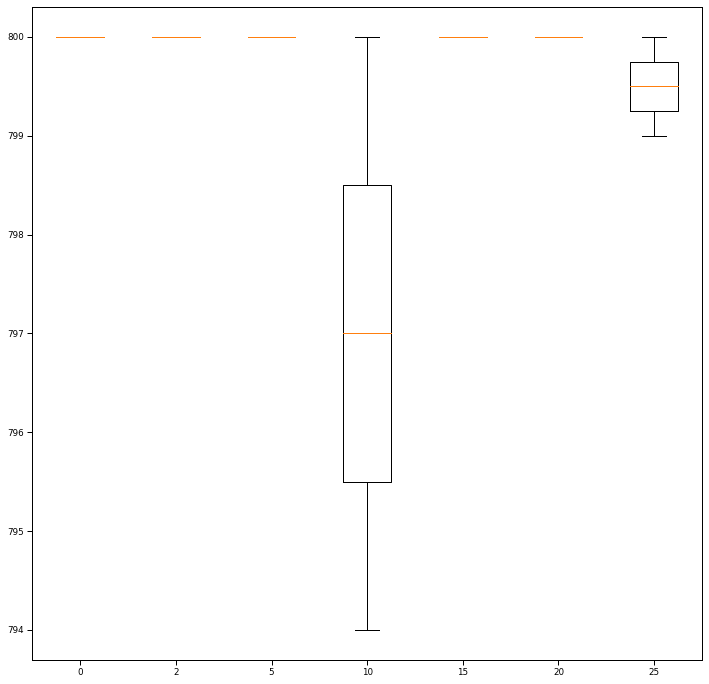

In [256]:
plot_quantiles(d, "Number of inliers")